In [1]:
import h5py
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
import numpy as np
import cv2
%matplotlib inline
import scipy

from itertools import cycle

import numpy as np
from scipy import ndimage
from scipy.ndimage import binary_dilation, binary_erosion
from msnake import MSnake

%load_ext autoreload
%autoreload 2
from tqdm import tqdm
import imageio
import os

plt.rcParams["font.family"] = "Times New Roman"
import matplotlib
matplotlib.rc('font',family='Times New Roman')

In [2]:
def stich(im1, im0):
    im = np.zeros(im1.shape)
    im[:, :256] = im1[:, :256]
    im[:, 256:] = im0[:, 256:]
    return im

def normalize(img):
    ma = np.max(img)
    mi = np.min(img)
    quo = ma - mi
    if quo == 0:
        return np.zeros(img.shape)
    return (img - mi)/(ma-mi)

In [ ]:
# dice

PATH_MASK_H5 ="/mnt/dfs/xjyan/269-deeplevelset-segmentation/experiments/269_unet2/test/unet2_3_11_predictions.h5"
PATH_INPUT_H5 = "/mnt/dfs/xjyan/patches/269_test_patch_2class.h5"
PATH_OUT_ROOT = "/home/xjyan/Desktop/sample_output/"

msk_h5 = h5py.File(PATH_MASK_H5, "r")
input_h5 = h5py.File(PATH_INPUT_H5, "r")

l_dice = list()
l_dice_tuple = list()

for i, k in tqdm(enumerate(list(np.random.choice(list(msk_h5.keys()), size=500, replace=False)))):
    g = msk_h5[k]
    nn_mask_0 = g["binary_mask"][0,:,:,0] 
    nn_mask_1 = g["binary_mask"][0,:,:,1] 
#     nn_mask_0 = np.zeros((512,512))
#     nn_mask_0[g["pmap"][0,:,:,0] > 0.4999] = 1  
#     nn_mask_1 = np.zeros((512,512))
#     nn_mask_1[g["pmap"][0,:,:,1] > 0.4999] = 1  
    
    img = input_h5[k]["ct_slice"][()]
    mask = input_h5[k]["mask"][()]
    
    msnake_0 = MSnake(nn_mask_0, img, iterations=50)
    _ = msnake_0.evolve()
    msnake_1 = MSnake(nn_mask_1, img, iterations=50)
    _ = msnake_1.evolve()
    nn_mask = np.stack([msnake_0.mask, msnake_1.mask], axis=-1)
    
    l_dice.append(np.sum(nn_mask * mask) * 2/(np.sum(nn_mask) + np.sum(mask)))
    l_dice_tuple.append((np.sum(nn_mask * mask) * 2/(np.sum(nn_mask) + np.sum(mask)),
                         np.sum(g["binary_mask"][0,:,:,:] * mask) * 2/(np.sum(g["binary_mask"][0,:,:,:]) + np.sum(mask))))
    
    # save resutls
    result = np.concatenate([normalize(img), 
                             stich(nn_mask_1, nn_mask_0), 
                             stich(nn_mask[:,:,1], nn_mask[:,:,0]), 
                             stich(mask[:,:,1], mask[:,:,0])], axis=1)
    imageio.imsave(PATH_OUT_ROOT + "/%s.png"%(i), result)
    
    
print(np.average(l_dice))

In [6]:

def dice(i1, i2):
    i1 = normalize(i1)
    i2 = normalize(i2)
    quo = (np.sum(i1) + np.sum(i2))
    if quo == 0:
        return 0
    
    return 2*np.sum(i1*i2)/quo


In [10]:
# top dice

l_top_mgac_dice = sorted(l_dice_tuple, key=lambda x: x[0], reverse=True)

print(np.average([i[0] for i in l_top_mgac_dice][:100]))
print(np.average([i[1] for i in l_top_mgac_dice][:100]))



0.912363331661
0.82916294213


In [3]:
# compute dice from image
R = "/home/xjyan/Desktop/sample_output/"

all_images = [imageio.imread(os.path.join(R, i)) for i in os.listdir(R)]

In [4]:
s = 256

all_imgs = [[i[:, j*s:(j+1)*s] for j in range(2, 8)] 
            for i in all_images]

In [7]:
# 0, 1; 2, 3; 4, 5

l_dice_R = [(dice(i[0], i[4]), dice(i[2], i[4])) for i in all_imgs]
l_dice_L = [(dice(i[1], i[5]), dice(i[3], i[5])) for i in all_imgs]
l_dice_all = [(dice(np.concatenate([i[0], i[1]]), np.concatenate([i[4], i[5]])), 
               dice(np.concatenate([i[2], i[3]]), np.concatenate([i[4], i[5]]))) 
              for i in all_imgs]

In [13]:
l_top_mgac_dice = sorted(l_dice_all, key=lambda x: x[1], reverse=True)

print(np.average([i[0] for i in l_top_mgac_dice][:200]))
print(np.average([i[1] for i in l_top_mgac_dice][:200]))

0.835053409156
0.928225659028


In [8]:
def _get_top(lt, i):
    lts = sorted(l_dice_all, key=lambda x: x[i], reverse=True)
    return [j[i] for j in lts]

def _roll_avg(l):
    return [np.average(l[:i+1]) for i in range(len(l))]

In [9]:
top_x = list(range(0, 500))

# left
top_nn_L = _get_top(l_dice_L, 0)
top_M_L = _get_top(l_dice_L, 1)
top_nn_L_avg = _roll_avg(top_nn_L)
top_M_L_avg = _roll_avg(top_M_L)

l_tup_top_M_L = sorted(l_dice_L, key=lambda x: x[1], reverse=True)
top_nn_L_cup = [i[0] for i in l_tup_top_M_L]
top_M_L_cup = [i[1] for i in l_tup_top_M_L]
top_nn_L_cup_avg = _roll_avg(top_nn_L_cup)
top_M_L_cup_avg = _roll_avg(top_M_L_cup)

# right
top_nn_R = _get_top(l_dice_R, 0)
top_M_R = _get_top(l_dice_R, 1)
top_nn_R_avg = _roll_avg(top_nn_R)
top_M_R_avg = _roll_avg(top_M_R)

l_tup_top_M_R = sorted(l_dice_R, key=lambda x: x[1], reverse=True)
top_nn_R_cup = [i[0] for i in l_tup_top_M_R]
top_M_R_cup = [i[1] for i in l_tup_top_M_R]
top_nn_R_cup_avg = _roll_avg(top_nn_R_cup)
top_M_R_cup_avg = _roll_avg(top_M_R_cup)

# all
top_nn_all = _get_top(l_dice_all, 0)
top_M_all = _get_top(l_dice_all, 1)
top_nn_all_avg = _roll_avg(top_nn_all)
top_M_all_avg = _roll_avg(top_M_all)

l_tup_top_M_all = sorted(l_dice_all, key=lambda x: x[1], reverse=True)
top_nn_all_cup = [i[0] for i in l_tup_top_M_all]
top_M_all_cup = [i[1] for i in l_tup_top_M_all]
top_nn_all_cup_avg = _roll_avg(top_nn_all_cup)
top_M_all_cup_avg = _roll_avg(top_M_all_cup)

/home/xjyan/.conda/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


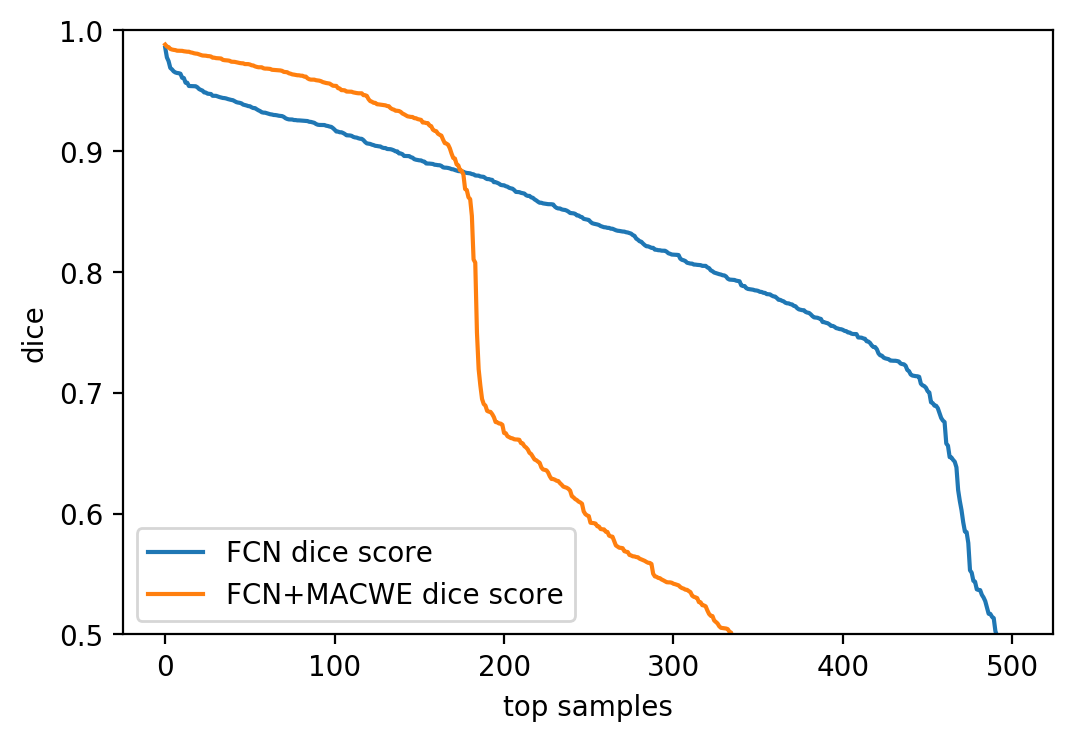

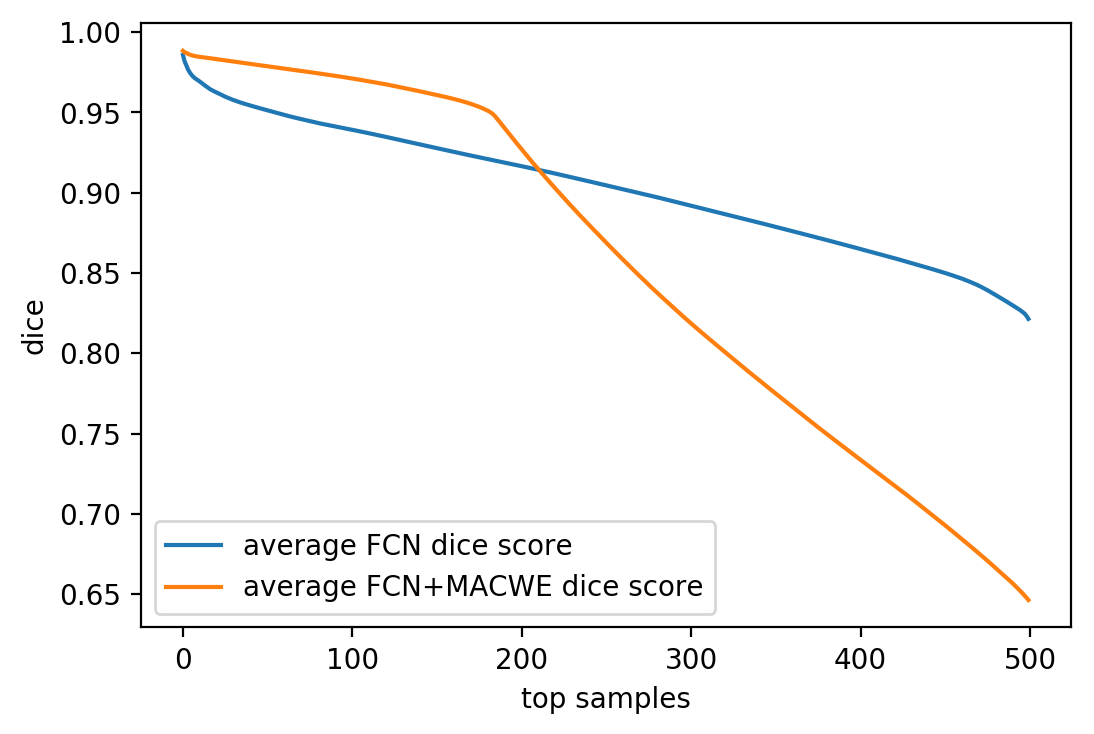

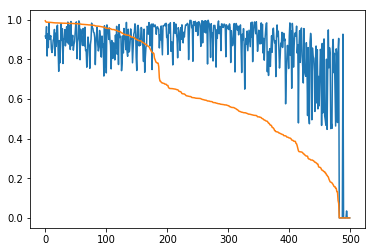

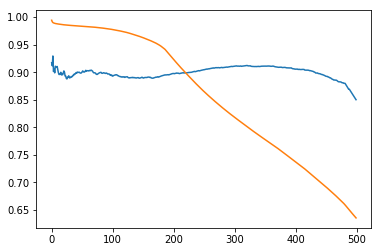

In [80]:
plt.figure(dpi=200)
plt.plot(top_x, top_nn_L)
plt.plot(top_x, top_M_L)
# plt.plot(top_x, top_nn_all)
plt.xlabel("top samples", **{'fontname':'Times New Roman'})
plt.ylabel("dice")
plt.ylim([0.5, 1])
plt.legend(["FCN dice score", "FCN+MACWE dice score"], loc="lower left")
plt.rc('font',family='Times New Roman')

plt.figure(dpi=200)
plt.plot(top_x, top_nn_L_avg)
plt.plot(top_x, top_M_L_avg)
plt.xlabel("top samples")
plt.ylabel("dice")
# plt.ylim([0.5, 1])
plt.legend(["average FCN dice score", "average FCN+MACWE dice score"], loc="lower left")

plt.figure()
plt.plot(top_x, top_nn_L_cup)
plt.plot(top_x, top_M_L_cup)

plt.figure()
plt.plot(top_x, top_nn_L_cup_avg)
plt.plot(top_x, top_M_L_cup_avg)


In [11]:
idx = [x[1] for x in sorted(zip(l_dice_L, range(len(l_dice_L))), key=lambda x: x[0][1], reverse=True)]

/home/xjyan/.conda/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


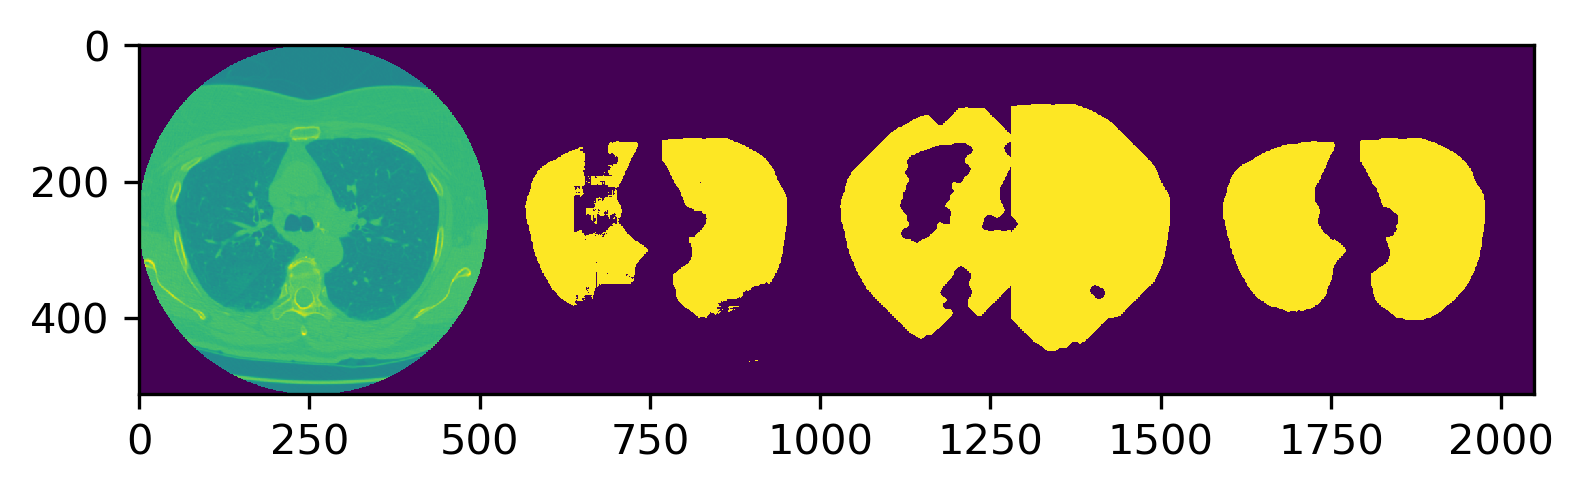

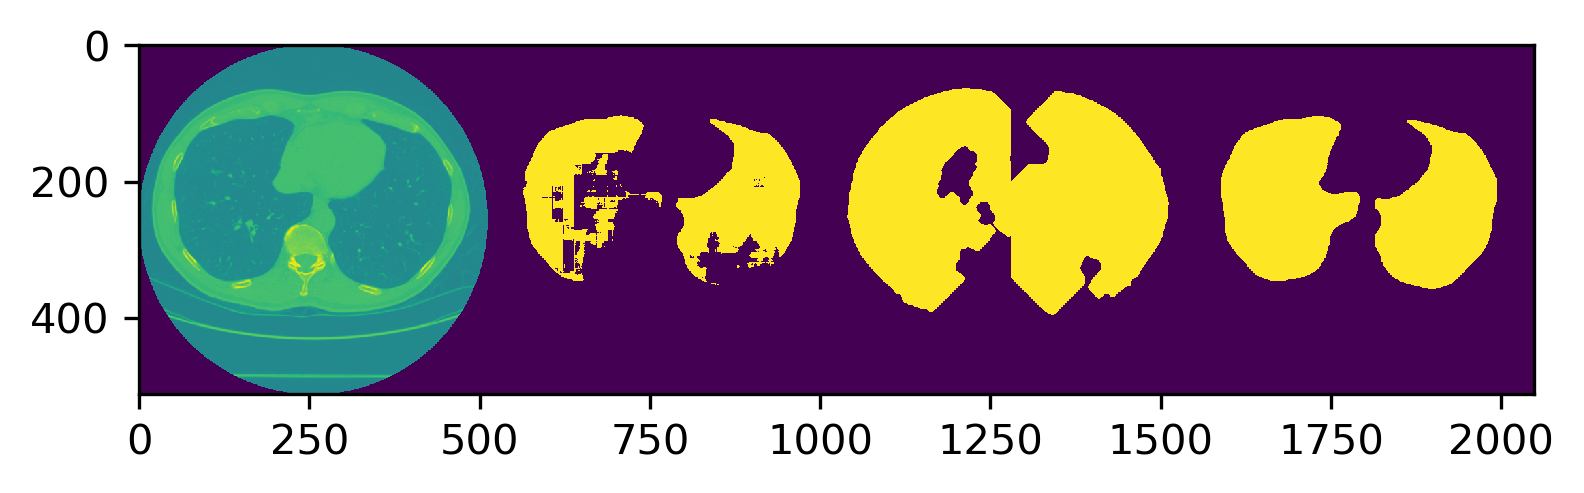

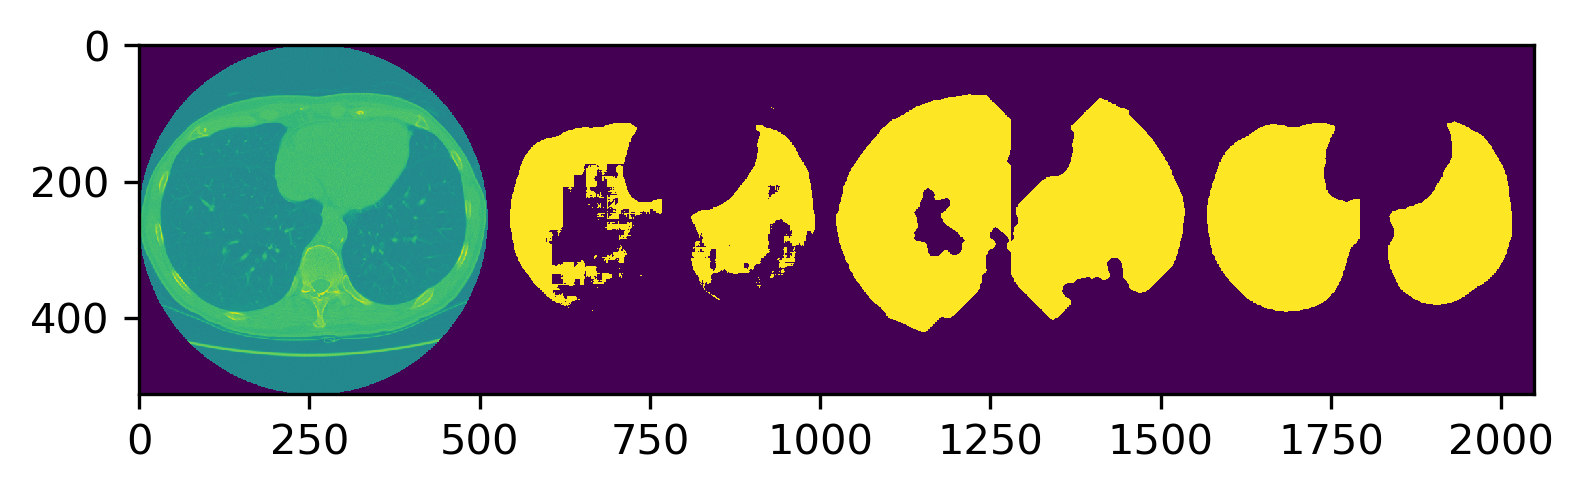

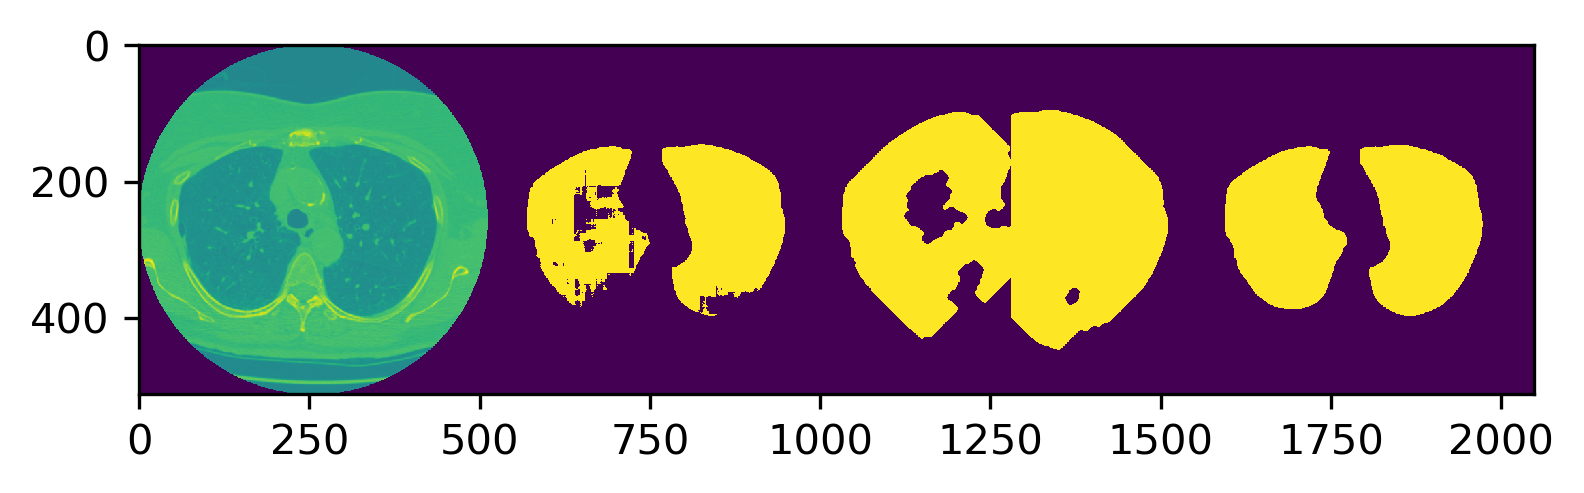

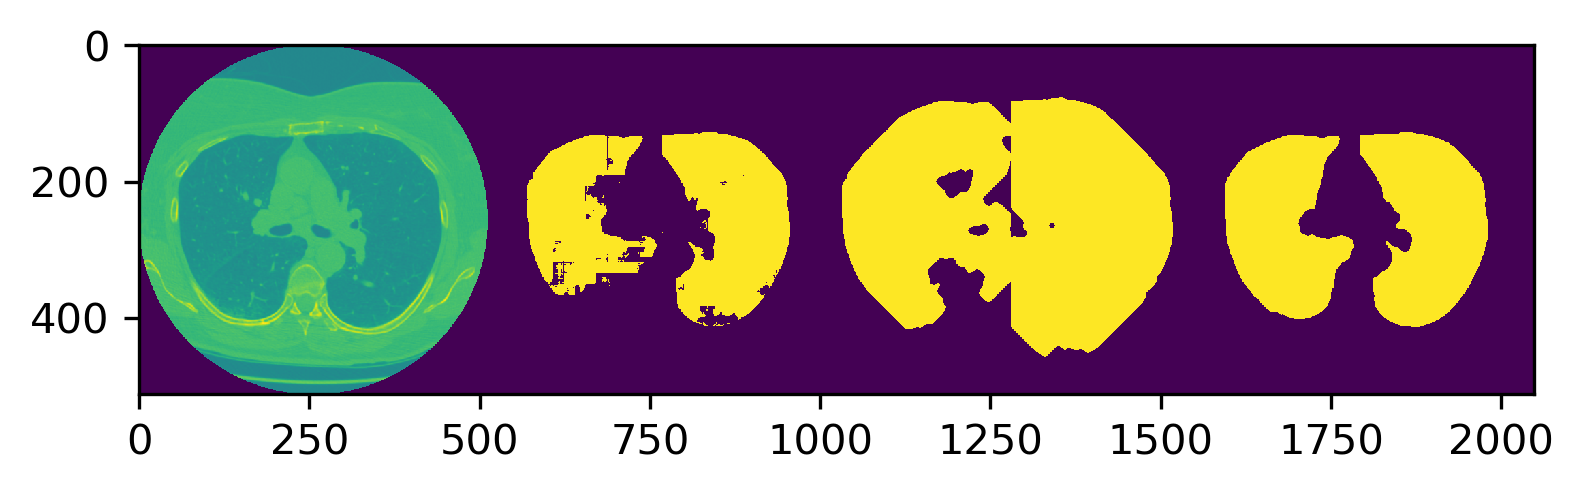

In [12]:
for i in range(190, 195):
    plt.figure(dpi=300)
    plt.imshow(all_images[idx[i]])

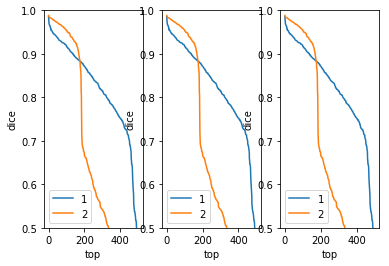

In [61]:
plt.figure()
plt.subplot(1,3,1)
plt.plot(top_x, top_nn_L)
plt.plot(top_x, top_M_L)
plt.xlabel("top")
plt.ylabel("dice")
plt.ylim([0.5, 1])
plt.legend(["1", "2"], loc="lower left")

plt.subplot(1,3,2)
plt.plot(top_x, top_nn_R)
plt.plot(top_x, top_M_R)
plt.xlabel("top")
plt.ylabel("dice")
plt.ylim([0.5, 1])
plt.legend(["1", "2"], loc="lower left")

plt.subplot(1,3,3)
plt.plot(top_x, top_nn_all)
plt.plot(top_x, top_M_all)
plt.xlabel("top")
plt.ylabel("dice")
plt.ylim([0.5, 1])
plt.legend(["1", "2"], loc="lower left")



In [14]:
(top_nn_L_avg[200], top_M_L_avg[200])

(0.91652606836713113, 0.92692478164921921)